# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 5,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 15, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'function_generation_type': 'make_classification_trained',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var15_class2_make_classification_trained_xMax1_xMin0_xDistuniform_depth5_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var15_class2_make_classification_trained_xMax1_xMin0_xDistuniform_depth5_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,split15,split16,split17,split18,split19,split20,split21,split22,split23,split24,split25,split26,split27,split28,split29,split30,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15,lp16,lp17,lp18,lp19,lp20,lp21,lp22,lp23,lp24,lp25,lp26,lp27,lp28,lp29,lp30,lp31
0,0.548,0.552,0.615,0.495,0.288,0.568,0.505,0.534,0.298,0.495,0.612,0.501,0.349,0.755,0.504,0.575,0.487,0.350,0.456,0.366,0.335,0.617,0.452,0.561,0.478,0.620,0.455,0.633,0.625,0.546,0.516,0.000,12.000,12.000,2.000,9.000,2.000,10.000,10.000,9.000,4.000,6.000,1.000,1.000,1.000,4.000,4.000,14.000,10.000,12.000,10.000,3.000,12.000,14.000,6.000,10.000,2.000,12.000,3.000,7.000,5.000,10.000,0.249,0.654,0.022,0.451,0.700,0.306,0.867,0.548,1.000,0.211,0.143,0.813,0.252,0.103,0.104,0.762,0.336,0.747,0.843,0.563,0.308,0.800,0.984,0.865,0.092,0.444,0.923,0.000,0.605,0.932,1.000,0.000
1,0.506,0.478,0.475,0.460,0.485,0.532,0.533,0.564,0.465,0.458,0.576,0.522,0.594,0.490,0.491,0.557,0.549,0.590,0.451,0.423,0.623,0.802,0.716,0.318,0.289,0.393,0.724,0.442,0.423,0.470,0.587,10.000,11.000,2.000,4.000,7.000,14.000,12.000,8.000,2.000,12.000,14.000,8.000,10.000,11.000,0.000,13.000,2.000,14.000,14.000,6.000,6.000,0.000,14.000,6.000,7.000,8.000,0.000,7.000,1.000,9.000,11.000,0.597,0.221,0.065,0.424,0.764,0.437,0.281,0.561,0.475,0.817,0.298,0.769,0.859,0.200,0.671,0.419,0.129,0.535,0.524,0.158,0.446,0.177,0.050,0.455,0.654,0.320,0.465,0.762,0.733,0.244,0.099,0.344
2,0.419,0.656,0.397,0.627,0.330,0.525,0.318,0.280,0.419,-1.000,0.394,0.565,0.559,0.540,0.144,0.286,0.589,-1.000,0.527,-1.000,-1.000,-1.000,0.206,0.501,0.273,0.281,-1.000,-1.000,-1.000,-1.000,0.497,7.000,0.000,11.000,13.000,13.000,0.000,0.000,12.000,0.000,-1.000,5.000,7.000,5.000,7.000,14.000,9.000,0.000,-1.000,5.000,-1.000,-1.000,-1.000,11.000,7.000,11.000,8.000,-1.000,-1.000,-1.000,-1.000,5.000,1.000,0.000,0.995,0.844,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.500,0.000,0.981,0.741,0.750,0.000,0.125,0.886,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.133,0.002
3,0.460,0.451,0.412,0.664,0.524,0.614,0.561,0.569,0.565,0.530,0.564,0.514,0.517,0.400,0.458,0.306,0.439,0.306,0.519,0.431,0.552,0.817,0.590,0.591,0.440,0.395,0.397,0.520,0.520,0.477,0.561,3.000,10.000,8.000,6.000,10.000,5.000,11.000,5.000,9.000,6.000,12.000,14.000,9.000,12.000,5.000,8.000,8.000,14.000,11.000,4.000,4.000,6.000,11.000,13.000,10.000,11.000,4.000,7.000,8.000,10.000,9.000,1.000,0.040,0.444,1.000,0.833,0.146,0.972,0.625,0.800,0.061,0.959,0.774,0.984,0.500,0.415,0.977,0.941,0.000,0.074,0.789,0.294,0.950,1.000,0.147,0.188,0.759,0.154,0.009,0.000,0.800,0.936,0.531
4,0.524,0.533,0.498,0.375,0.439,0.524,0.686,0.628,0.562,0.740,0.633,0.549,0.559,0.177,0.676,0.254,0.474,0.578,0.335,0.703,0.412,0.751,0.522,0.547,0.258,0.643,0.523,0.429,0.319,0.617,-1.000,6.000,1.000,4.000,9.000,10.000,8.000,14.000,4.000,14.000,12.000,9.000,13.000,10.000,1.000,8.000,7.000,2.000,0.000,7.000,0.000,2.000,8.000,5.000,12.000,7.000,7.000,9.000,9.000,2.000,6.000,-1.000,0.000,0.922,0.964,0.161,0.266,0.670,0.393,0.722,0.290,0.013,0.200,0.900,0.633,0.184,0.109,0.681,0.430,0.696,0.143,0.932,0.123,0.941,0.902,0.318,1.000,0.182,0.750,0.072,0.771,0.077,0.000,0.000


In [11]:
X_data_list[0][0].head(10)

feat0   0.548
feat1   0.552
feat2   0.615
feat3   0.495
feat4   0.288
feat5   0.568
feat6   0.505
feat7   0.534
feat8   0.298
feat9   0.495
dtype: float64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,0.477,0.256,0.482,0.418,0.574,0.301,0.191,0.596,0.347,0.285,0.357,0.595,0.372,0.516,0.552
1,0.519,0.467,0.560,0.539,0.510,0.423,0.311,0.425,0.411,0.375,0.391,0.622,0.655,0.532,0.312
2,0.619,0.399,0.499,0.371,0.290,0.441,0.556,0.506,0.634,0.500,0.557,0.550,0.570,0.730,0.582
3,0.570,0.492,0.278,0.672,0.613,0.668,0.441,0.536,0.299,0.487,0.580,0.122,0.515,0.503,0.374
4,0.413,0.501,0.525,0.613,0.543,0.600,0.456,0.629,0.570,0.450,0.633,0.663,0.511,0.535,0.444
5,0.739,0.743,0.509,0.570,0.528,0.454,0.451,0.507,0.429,0.331,0.359,0.332,0.482,0.618,0.320
6,0.221,0.687,0.520,0.352,0.646,0.630,0.545,0.554,0.597,0.318,0.485,0.718,0.428,0.357,0.531
7,0.405,0.501,0.336,0.619,0.539,0.777,0.335,0.449,0.681,0.631,0.658,0.551,0.622,0.553,0.641
8,0.363,0.593,0.721,0.578,0.456,0.500,0.411,0.508,0.404,0.325,0.520,0.600,0.556,0.616,0.486
9,0.484,0.488,0.324,0.639,0.564,0.580,0.468,0.659,0.498,0.222,0.595,0.543,0.384,0.657,0.570


In [13]:
y_data_list[0][0].head(10)

feat0   0.548
feat1   0.552
feat2   0.615
feat3   0.495
feat4   0.288
feat5   0.568
feat6   0.505
feat7   0.534
feat8   0.298
feat9   0.495
dtype: float64

In [14]:
y_data_list[0][1].head(10)

,result
0,1
1,1
2,1
3,1
4,0
5,0
6,0
7,1
8,1
9,1


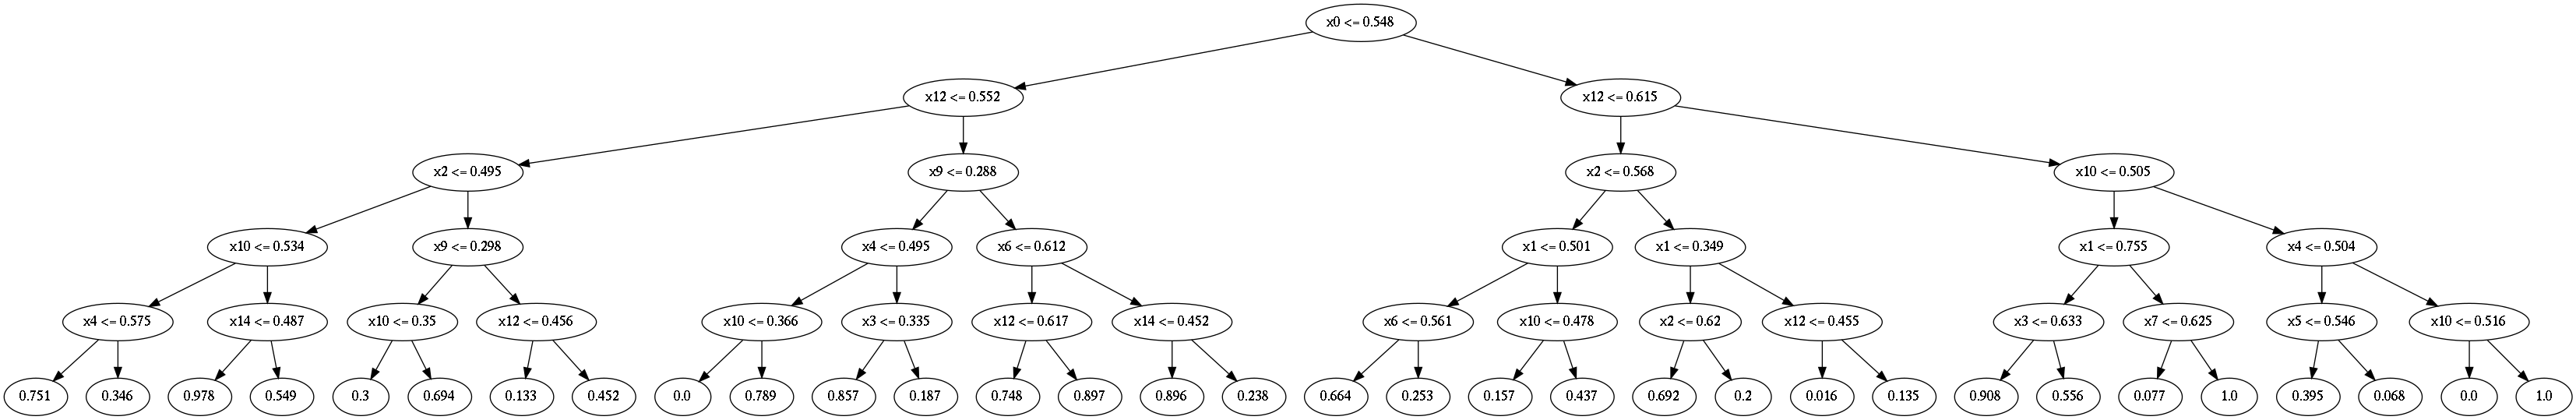

In [15]:
plot = None
if plot_tree_from_parameters != 'make_classification':
    plot = plot_tree_from_parameters(y_data_list[0][0].values, config)
plot

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0   0.548
feat1   0.552
feat2   0.615
feat3   0.495
feat4   0.288
feat5   0.568
feat6   0.505
feat7   0.534
feat8   0.298
feat9   0.495
dtype: float64

In [19]:
y_data_list[0][0]

feat0   0.548
feat1   0.552
feat2   0.615
feat3   0.495
feat4   0.288
         ... 
lp27    0.000
lp28    0.605
lp29    0.932
lp30    1.000
lp31    0.000
Length: 94, dtype: float64

In [20]:
y_data_list[0][1].head(10)

,result
0,1
1,1
2,1
3,1
4,0
5,0
6,0
7,1
8,1
9,1


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

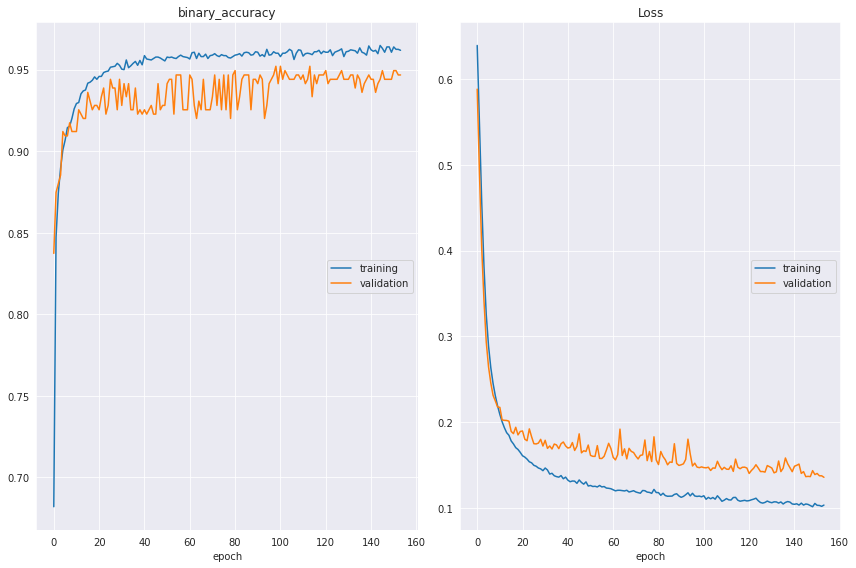

binary_accuracy
	training         	 (min:    0.682, max:    0.965, cur:    0.962)
	validation       	 (min:    0.837, max:    0.952, cur:    0.947)
Loss
	training         	 (min:    0.102, max:    0.639, cur:    0.103)
	validation       	 (min:    0.136, max:    0.588, cur:    0.136)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [24]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-3)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-3)]: Done 228 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-3)]: Done 452 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-3)]: Done 740 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-3)]: Done 1092 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-3)]: Done 1508 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-3)]: Done 1988 tasks      | elapsed: 47.0min
[Parallel(n_jobs=-3)]: Done 2532 tasks      | elapsed: 59.5min
[Parallel(n_jobs=-3)]: Done 3140 tasks      | elapsed: 73.5min
[Parallel(n_jobs=-3)]: Done 3812 tasks      | elapsed: 89.2min
[Parallel(n_jobs=-3)]: Done 4548 tasks      | elapsed: 106.4min
[Parallel(n_jobs=-3)]: Done 5348 tasks      | elapsed: 124.9min
[Parallel(n_jobs=-3)]: Done 6212 tasks      | elapsed: 145.0min
[Parallel(n_jobs=-3)]: Done 7140 tasks      | elapsed: 166.9min
[Parallel(n_jobs=-3)]: Done 8132 tasks   

In [25]:
random_network['model'].get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 15),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 15),
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initial

In [26]:
random_network['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [27]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [28]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [29]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_351,loss_epoch_352,loss_epoch_353,loss_epoch_354,loss_epoch_355,loss_epoch_356,loss_epoch_357,loss_epoch_358,loss_epoch_359,loss_epoch_360,loss_epoch_361,loss_epoch_362,loss_epoch_363,loss_epoch_364,loss_epoch_365,loss_epoch_366,loss_epoch_367,loss_epoch_368,loss_epoch_369,loss_epoch_370,loss_epoch_371,loss_epoch_372,loss_epoch_373,loss_epoch_374,loss_epoch_375,loss_epoch_376,loss_epoch_377,loss_epoch_378,loss_epoch_379,loss_epoch_380,loss_epoch_381,loss_epoch_382,loss_epoch_383,loss_epoch_384,loss_epoch_385,loss_epoch_386,loss_epoch_387,loss_epoch_388,loss_epoch_389,loss_epoch_390,loss_epoch_391,loss_epoch_392,loss_epoch_393,loss_epoch_394,loss_epoch_395,loss_epoch_396,loss_epoch_397,loss_epoch_398,loss_epoch_399,loss_epoch_400,loss_epoch_401,loss_epoch_402,loss_epoch_403,loss_epoch_404,loss_epoch_405,loss_epoch_406,loss_epoch_407,loss_epoch_408,loss_epoch_409,loss_epoch_410,loss_epoch_411,loss_epoch_412,loss_epoch_413,loss_epoch_414,loss_epoch_415,loss_epoch_416,loss_epoch_417,loss_epoch_418,loss_epoch_419,loss_epoch_420,loss_epoch_421,loss_epoch_422,loss_epoch_423,loss_epoch_424,loss_epoch_425,loss_epoch_426,loss_epoch_427,loss_epoch_428,loss_epoch_429,loss_epoch_430,loss_epoch_431,loss_epoch_432,loss_epoch_433,loss_epoch_434,loss_epoch_435,loss_epoch_436,loss_epoch_437,loss_epoch_438,loss_epoch_439,loss_epoch_440,loss_epoch_441,loss_epoch_442,loss_epoch_443,loss_epoch_444,loss_epoch_445,loss_epoch_446,loss_epoch_447,loss_epoch_448,loss_epoch_449,loss_epoch_450
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9997.000,9986.000,9981.000,9976.000,9963.000,9943.000,9923.000,9910.000,9896.000,9880.000,9861.000,9838.000,9817.000,9794.000,9780.000,9760.000,9744.000,9728.000,9720.000,9705.000,9695.000,9684.000,9671.000,9660.000,9648.000,9633.000,9621.000,9604.000,9592.000,9578.000,9568.000,9552.000,9539.000,9528.000,9515.000,9504.000,9492.000,9479.000,9469.000,9455.000,...,55.000,55.000,54.000,53.000,52.000,51.000,50.000,49.000,47.000,46.000,43.000,43.000,41.000,41.000,38.000,35.000,33.000,32.000,30.000,29.000,28

In [30]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_351,val_loss_epoch_352,val_loss_epoch_353,val_loss_epoch_354,val_loss_epoch_355,val_loss_epoch_356,val_loss_epoch_357,val_loss_epoch_358,val_loss_epoch_359,val_loss_epoch_360,val_loss_epoch_361,val_loss_epoch_362,val_loss_epoch_363,val_loss_epoch_364,val_loss_epoch_365,val_loss_epoch_366,val_loss_epoch_367,val_loss_epoch_368,val_loss_epoch_369,val_loss_epoch_370,val_loss_epoch_371,val_loss_epoch_372,val_loss_epoch_373,val_loss_epoch_374,val_loss_epoch_375,val_loss_epoch_376,val_loss_epoch_377,val_loss_epoch_378,val_loss_epoch_379,val_loss_epoch_380,val_loss_epoch_381,val_loss_epoch_382,val_loss_epoch_383,val_loss_epoch_384,val_loss_epoch_385,val_loss_epoch_386,val_loss_epoch_387,val_loss_epoch_388,val_loss_epoch_389,val_loss_epoch_390,val_loss_epoch_391,val_loss_epoch_392,val_loss_epoch_393,val_loss_epoch_394,val_loss_epoch_395,val_loss_epoch_396,val_loss_epoch_397,val_loss_epoch_398,val_loss_epoch_399,val_loss_epoch_400,val_loss_epoch_401,val_loss_epoch_402,val_loss_epoch_403,val_loss_epoch_404,val_loss_epoch_405,val_loss_epoch_406,val_loss_epoch_407,val_loss_epoch_408,val_loss_epoch_409,val_loss_epoch_410,val_loss_epoch_411,val_loss_epoch_412,val_loss_epoch_413,val_loss_epoch_414,val_loss_epoch_415,val_loss_epoch_416,val_loss_epoch_417,val_loss_epoch_418,val_loss_epoch_419,val_loss_epoch_420,val_loss_epoch_421,val_loss_epoch_422,val_loss_epoch_423,val_loss_epoch_424,val_loss_epoch_425,val_loss_epoch_426,val_loss_epoch_427,val_loss_epoch_428,val_loss_epoch_429,val_loss_epoch_430,val_loss_epoch_431,val_loss_epoch_432,val_loss_epoch_433,val_loss_epoch_434,val_loss_epoch_435,val_loss_epoch_436,val_loss_epoch_437,val_loss_epoch_438,val_loss_epoch_439,val_loss_epoch_440,val_loss_epoch_441,val_loss_epoch_442,val_loss_epoch_443,val_loss_epoch_444,val_loss_epoch_445,val_loss_epoch_446,val_loss_epoch_447,val_loss_epoch_448,val_loss_epoch_449,val_loss_epoch_450
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,

In [31]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_351,binary_accuracy_epoch_352,binary_accuracy_epoch_353,binary_accuracy_epoch_354,binary_accuracy_epoch_355,binary_accuracy_epoch_356,binary_accuracy_epoch_357,binary_accuracy_epoch_358,binary_accuracy_epoch_359,binary_accuracy_epoch_360,binary_accuracy_epoch_361,binary_accuracy_epoch_362,binary_accuracy_epoch_363,binary_accuracy_epoch_364,binary_accuracy_epoch_365,binary_accuracy_epoch_366,binary_accuracy_epoch_367,binary_accuracy_epoch_368,binary_accuracy_epoch_369,binary_accuracy_epoch_370,binary_accuracy_epoch_371,binary_accuracy_epoch_372,binary_accuracy_epoch_373,binary_accuracy_epoch_374,binary_accuracy_epoch_375,binary_accuracy_epoch_376,binary_accuracy_epoch_377,binary_accuracy_epoch_378,binary_accuracy_epoch_379,binary_accuracy_epoch_380,binary_accuracy_epoch_381,binary_accuracy_epoch_382,binary_accuracy_epoch_383,binary_accuracy_epoch_384,binary_accuracy_epoch_385,binary_accuracy_epoch_386,binary_accuracy_epoch_387,binary_accuracy_epoch_388,binary_accuracy_epoch_389,binary_accuracy_epoch_390,binary_accuracy_epoch_391,binary_accuracy_epoch_392,binary_accuracy_epoch_393,binary_accuracy_epoch_394,binary_accuracy_epoch_395,binary_accuracy_epoch_396,binary_accuracy_epoch_397,binary_accuracy_epoch_398,binary_accuracy_epoch_399,binary_accuracy_epoch_400,binary_accuracy_epoch_401,binary_accuracy_epoch_402,binary_accuracy_epoch_403,binary_accuracy_epoch_404,binary_accuracy_epoch_405,binary_accuracy_epoch_406,binary_accuracy_epoch_407,binary_accuracy_epoch_408,binary_accuracy

In [32]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_351,val_binary_accuracy_epoch_352,val_binary_accuracy_epoch_353,val_binary_accuracy_epoch_354,val_binary_accuracy_epoch_355,val_binary_accuracy_epoch_356,val_binary_accuracy_epoch_357,val_binary_accuracy_epoch_358,val_binary_accuracy_epoch_359,val_binary_accuracy_epoch_360,val_binary_accuracy_epoch_361,val_binary_accuracy_epoch_362,val_binary_accuracy_epoch_363,val_binary_accuracy_epoch_364,val_binary_accuracy_epoch_365,val_binary_accuracy_epoch_366,val_binary_accuracy_epoch_367,val_binary_accuracy_epoch_368,val_binary_accuracy_epoch_369,val_binary_accuracy_epoch_370,val_binary_accuracy_epoch_371,val_binary_accuracy_epoch_372,val_binary_accuracy_epoch_373,val_binary_accuracy_epoch_374,val_binary_accuracy_epoch_375,val_binary_accuracy_epoch_376,val_binary_accuracy_epoch_377,val_binary_accuracy_epoch_378,val_binary_accuracy_epoch_379,val_binary_accuracy_epoch_380,val_binary_accuracy_epoch_381,val_binary_accuracy_epoch_382,val_binary_accuracy_epoch_383,val_binary_accuracy_epoch_384,val_binary_accuracy_epoch_385,val_binary_accuracy_epoch_386,val_binary_accuracy_epoch_387,val_binary_accura

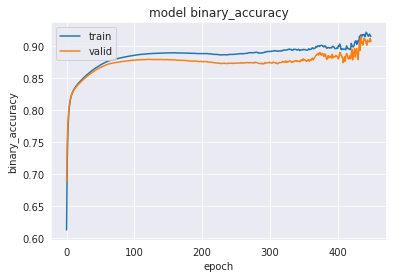

In [33]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


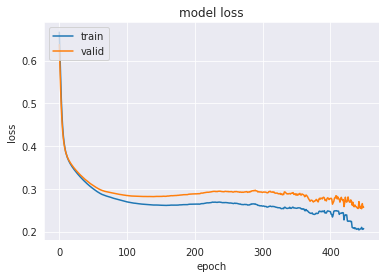

In [34]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [35]:
print('a')

a
